In [759]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [760]:
%reload_ext autoreload

In [684]:
# Standart Libraries

import numpy as np

# Import files

import utilities
from Filter import ExtendedKalmanFilter
from Radar import Radar
from RadarSystem import RadarSystem
from Earth import Earth
from Satellite import Satellite
from SatelliteState import SatelliteState

from config import config


In [790]:
# Initialize Earth
earth = Earth()


# Initialize RadarSystem
# Beijing Aerospace Command and Control Center

BACC =  RadarSystem( Earth(),counts=500)


# Initialize Satellite
R = config['satellite']['initial_conditions']['distance']
theta = config['satellite']['initial_conditions']['polar_angle']
phi = config['satellite']['initial_conditions']['azimuthal_angle']

#phi = config['satellite']['initial_conditions']['polar_angle']
#theta = config['satellite']['initial_conditions']['azimuthal_angle']


angular_vel = 0.0010830807404
tang_vel = angular_vel * R
radial_velocity = 0
azimuthal_velocity = 0


sat_state = SatelliteState(np.array([R, theta, phi]), np.array([0]), np.array([radial_velocity, tang_vel, azimuthal_velocity]), np.array([0]))
tiagong = Satellite(sat_state, 0, earth=earth)

In [791]:
list_position = np.array([radar.position for radar in BACC.radars])

In [792]:
# Initialize the Kalman Filter
# tianhe is the chinese super computer

#mean_0 = np.array([earth.re+380000, 0, 0.1, np.pi/2, angular_vel, 0])
r_noise = config['radar']['noise']['rho']
t_noise = config['radar']['noise']['theta']
mean_0 = np.array([earth.re, 0, 0, np.pi, 0, 0])

# cov_0 = np.array([
#     [3.98e8, 0, 0, 0, 0, 0],
#     [0, 1.092e1, 0, 0, 0, 0],
#     [0, 0, 1e0, 0, 0, 0],
#     [0, 0, 0, 1.9533, 0, 0],
#     [0, 0, 0, 0, 5.194e-1, 0],
#     [0, 0, 0, 0, 0, 8.03e-2]
# ])

cov_0 = np.array([
    [1e8, 0, 0, 0, 0, 0],
    [0, 1e4, 0, 0, 0, 0],
    [0, 0, 1e1, 0, 0, 0],
    [0, 0, 0, 1e3, 0, 0],
    [0, 0, 0, 0, 1e1, 0],
    [0, 0, 0, 0, 0, 1e-1]
])

observation_noise = np.array([[r_noise, 0],
              [0, 0.0001]])

Q = np.array([
    [100, 0, 0, 0, 0, 0],
    [0, 1, 0, 0, 0, 0],
    [0, 0, 0.1, 0, 0, 0],
    [0, 0, 0, 0.2, 0, 0],
    [0, 0, 0, 0, 0.02, 0],
    [0, 0, 0, 0, 0, 0.002]
])

tianhe = ExtendedKalmanFilter(mean_0, cov_0, earth, observation_noise=observation_noise, process_noise=Q)


In [793]:
n = 10000000
simulation = tiagong.simulate(10000000)

sim_lenght = len(simulation.y[0])


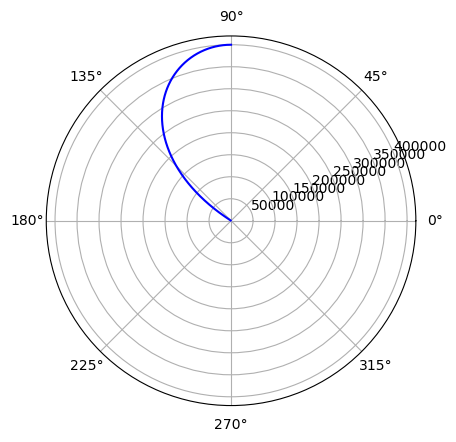

In [794]:
import numpy as np
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as axes3d

#n=np.argmin(np.abs(sol.y[0]-earth_radius))

R = simulation.y[0][:]-6378136.6
rad = simulation.y[2][:]
Phi = [np.pi/2 for i in rad]

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.plot(rad, R, c='b')

plt.show()

In [795]:
from copy import deepcopy

In [796]:
m = deepcopy(mean_0)

In [797]:
m = np.array([m[0], m[3]])

In [798]:
predicted_states_satellite_cord = [m]
radar_states_satellite_cord = [m]

In [799]:
for i in range(int(sim_lenght)):
    
    if i < sim_lenght:
        current_state_satellite_cord = tiagong.get_position_at_t(i)
        current_state_earth_cord = utilities.spherical_to_spherical(current_state_satellite_cord)
        noise_states_earth_cord = BACC.try_detect_satellite(current_state_earth_cord, i)
        #print(len(noise_states_earth_cord))

        #print(len(noise_states_earth_cord))
        if len(noise_states_earth_cord) > 0:
            #print("Enter")
            flag = 0
            for state_earth_cord in noise_states_earth_cord:
                #print("Update0")
                state_satellite_cord = utilities.spherical_to_spherical(state_earth_cord.pos)
                new_state_satellite_cord = tianhe.update(state_satellite_cord[:2])

                if flag == 0:
                    radar_states_satellite_cord += state_satellite_cord[:2],
                    flag = 1
            
    forecast = tianhe.forecast()
    new_state_satellite_cord = [forecast[0][0][0], forecast[0][3][0]]

    predicted_states_satellite_cord += new_state_satellite_cord,

    #if earth.distance_to_surface(utilities.spherical_to_spherical(np.array([forecast[0][0][0], forecast[0][3][0], config['satellite']['initial_conditions']['azimuthal_angle']])))['inside']:
        #break




In [800]:
R2, rad2 = np.array(predicted_states_satellite_cord[:]).T
R2 = R2 - 6378136.6
Phi = [np.pi/2 for i in rad]

In [801]:
radar_states_satellite_cord

R3, rad3 = np.array(radar_states_satellite_cord[1:]).T
R3 = R3 - 6378136.6

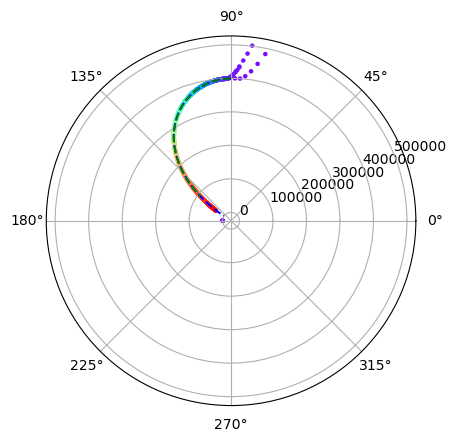

In [802]:
import numpy as np
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as axes3d


fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})

colors = plt.cm.rainbow(np.linspace(0, 1, len(R2)))

ax.plot(rad, R, c='b', linestyle="dashed")
ax.scatter(rad2, R2, c=colors, s=5)
ax.plot(rad3, R3, c='g', linestyle="dashed")

plt.show()

In [763]:

J = config['satellite']['initial_conditions']['azimuthal_angle']
NFK = []
for i in range(len(radar_states_satellite_cord))[1:]:
    NFK.append(np.array([radar_states_satellite_cord[i][0],radar_states_satellite_cord[i][1], J]))
x, z, y = utilities.earth_to_xyz_bulk(np.array(NFK).T)


R = simulation.y[0][:]
rad = simulation.y[2][:]
J = config['satellite']['initial_conditions']['azimuthal_angle']
NFK2 = []
for i in range(len(R)):
    NFK2.append(np.array([R[i],rad[i], J]))
x2, z2, y2 = utilities.earth_to_xyz_bulk(np.array(NFK2).T)


UnboundLocalError: cannot access local variable 'cartesian_state' where it is not associated with a value

In [ ]:
from RadarSystem import RadarSystem
import utilities
from Earth import Earth
from IPython.core.display_functions import clear_output
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from ipywidgets import interact, FloatSlider, Output, Button
import time

class Visualisation:
    def __init__(self, x_positions, y_positions, z_positions, x2, y2, z2, radar_positions=None, radars=None):
        self.x_positions = x_positions
        self.y_positions = y_positions
        self.z_positions = z_positions

        self.x_positions2 = x2
        self.y_positions2 = y2
        self.z_positions2 = z2

        self.radarSystem = radars


    re = Earth().re
    rp = Earth().rp
    show_range = 8000000

    def update_view(self, elev=30, azim=30):
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')
        ax.set_xlim([-self.show_range * 1.1, self.show_range * 1.1])
        ax.set_ylim([-self.show_range * 1.1, self.show_range * 1.1])
        ax.set_zlim([-self.show_range * 0.1, self.show_range * 0.1])
        ax.set_xlim([-self.show_range, self.show_range])
        ax.set_ylim([-self.show_range, self.show_range])
        ax.set_zlim([-self.show_range, self.show_range])

        # Earth surface
        u = np.linspace(0, 2 * np.pi, 200)
        v = np.linspace(0, np.pi, 200)
        x = self.re * np.outer(np.cos(u), np.sin(v))
        y = self.re * np.outer(np.sin(u), np.sin(v))
        z = self.rp * np.outer(np.ones(np.size(u)), np.cos(v))

        ax.plot_surface(x, y, z, color='b', rstride=4, cstride=4, alpha=0.5)
        ax.plot(self.x_positions, self.y_positions, self.z_positions, 'g')
        ax.plot(self.x_positions2, self.y_positions2, self.z_positions2,'b', linestyle='dashed')



        view_xs = []
        view_ys = []
        view_zs = []

        for i in range(len(self.x_positions)):
            pos = np.array([self.x_positions[i],self.y_positions[i],self.z_positions[i]])
            pos1 = utilities.c_to_p(pos)
            # print(pos)
            # print(pos1)
            # print("pos1")
            states = self.radarSystem.try_detect_satellite(pos1, i)
            #print(utilities.p_to_c(self.radarSystem.radars[0].position))
            if len(states) > 0:
                # print(states[0])
                c_pos = utilities.p_to_c(states[0].pos)
                view_xs.append(c_pos[0])
                view_ys.append(c_pos[1])
                view_zs.append(c_pos[2])

        ax.scatter(view_xs,view_ys,view_zs, color='r')
        # print("a")
        # print(view_xs)
        # print(view_ys)
        # print(view_zs)
        ax.view_init(elev=elev, azim=azim)
        # Plot radar positions
        for radar in self.radarSystem.radars:
            position = utilities.p_to_c(radar.position)
            ax.scatter(position[0], position[1], position[2], color='r', marker='o')
        ax.view_init(90,-90)
        plt.show()

orbit_radius = Earth().re + 2000000
theta = np.linspace(0, 2 * np.pi, 100)
orbit_x = orbit_radius * np.cos(theta)
orbit_y = orbit_radius * np.sin(theta)
orbit_z = np.zeros_like(orbit_x)
# Update the instantiation of the Visualisation class to include radar positions
visual = Visualisation(x, y, z, x2, y2, z2, radars=BACC)
visual.update_view()


NameError: name 'x' is not defined